In [1]:
import os
import csv
import gym
import argparse
import numpy as np
import pickle
import pyvirtualdisplay
from livelossplot import PlotLosses
from collections import deque

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from dqn_agent import DQNAgent

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
ENV_NAME_TRAIN = 'LunarLander-v2' ## CartPole-v0, MountainCar-v0, LunarLander-v2
RENDER_TRAIN = False

NUM_TRAIN_EPS = 10 #1000
NUM_MEM_FILL_EPS = 5 #10

DISCOUNT = 0.99
BATCHSIZE = 64
MEMORY_CAPACITY = 5000
UPDATE_FREQUENCY = 1000

EPS_MAX = 1.0
EPS_MIN = 0.01
EPS_DECAY = 0.99

TRAIN_SEED = 12321

BINDER_IN_USE = os.environ.get('BINDER_SERVICE_HOST') is not None

In [3]:
if BINDER_IN_USE: # test if running in Binder or locally
    _display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
    _ = _display.start()

In [4]:
def get_display_screen(env, render):
    env.reset()
    if not render:
        return None
    return plt.imshow(env.render(mode='rgb_array')) # only call this once

In [5]:
def render_env(env, display_screen):
    display_screen.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [6]:
def set_seeds(env, seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    env.seed(seed)
    env.action_space.np_random.seed(seed)

In [7]:
def fill_memory(env, dqn_agent):
    for _ in range(NUM_MEM_FILL_EPS):
        done = False
        state = env.reset()

        while not done:
            action = env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            dqn_agent.memory.store(state=state, action=action, next_state=next_state, reward=reward, done=done)

In [8]:
def train_loop(env, agent, display_screen, results_basepath):
    
    liveloss = PlotLosses()
    logs = {}
    
    last_100_rewards = deque([], maxlen=100)
    
    reward_history = []
    epsilon_history = []
    
    step_cnt = 0
    best_score = -np.inf

    for ep_cnt in range(NUM_TRAIN_EPS):
        
        logs['train epsilon'] = agent.epsilon
        
        done = False
        state = env.reset()

        ep_score = 0

        while not done:
            if display_screen is not None:
                render_env(env=env, display_screen=display_screen)
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            agent.memory.store(state=state, action=action, next_state=next_state, reward=reward, done=done)
            agent.learn(BATCHSIZE)
            
            if step_cnt % UPDATE_FREQUENCY == 0:
                agent.update_target_net()

            state = next_state
            ep_score += reward
            step_cnt += 1

        agent.update_epsilon()

        last_100_rewards.append(ep_score)
        current_avg_score = np.mean(last_100_rewards) # get average of last 100 scores
        logs['train avg score'] = current_avg_score
        
        if not BINDER_IN_USE:
            reward_history.append(ep_score)
            epsilon_history.append(logs['train epsilon'])
        
        if current_avg_score >= best_score:
            agent.save_model('{}/policy_model_best'.format(results_basepath))
            best_score = current_avg_score
            
        liveloss.update(logs)
        liveloss.send()
        
    if not BINDER_IN_USE:
        with open('{}/train_reward_history.pkl'.format(results_basepath), 'wb') as f:
            pickle.dump(reward_history, f)

        with open('{}/train_epsilon_history.pkl'.format(results_basepath), 'wb') as f:
            pickle.dump(epsilon_history, f)


In [9]:
results_basepath_train = "results/{}_epsmax{}_epsmin{}_epsdec{}_batchsize{}_treps{}_memeps{}".format(
                                                                                                ENV_NAME_TRAIN,
                                                                                                EPS_MAX, 
                                                                                                EPS_MIN, 
                                                                                                EPS_DECAY, 
                                                                                                BATCHSIZE,
                                                                                                NUM_TRAIN_EPS,
                                                                                                NUM_MEM_FILL_EPS)
os.makedirs(results_basepath_train, exist_ok=True)

env_train = gym.make(ENV_NAME_TRAIN)
set_seeds(env_train, TRAIN_SEED)

dqn_agent_train = DQNAgent(device, 
                            env_train.observation_space.shape[0], 
                            env_train.action_space.n, 
                            discount=DISCOUNT, 
                            eps_max=EPS_MAX, 
                            eps_min=EPS_MIN, 
                            eps_decay=EPS_DECAY,
                            memory_capacity=MEMORY_CAPACITY)

display_screen_train = get_display_screen(env_train, RENDER_TRAIN)

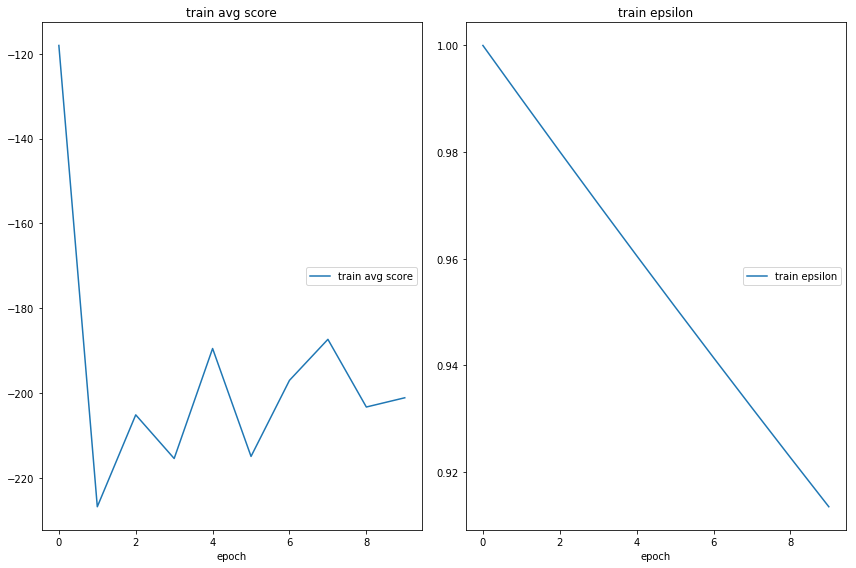

train avg score
	train avg score  	 (min: -226.797, max: -118.023, cur: -201.102)
train epsilon
	train epsilon    	 (min:    0.914, max:    1.000, cur:    0.914)


In [10]:
fill_memory(env_train, dqn_agent_train) 
train_loop(env_train, dqn_agent_train, display_screen_train, results_basepath_train)

In [ ]:
#RESULTS_BASEPATH_TEST = 'results/CartPole-v0_epsmax1.0_epsmin0.01_epsdec0.99_batchsize64_treps1000_memeps10'
#RESULTS_BASEPATH_TEST = 'dqn_res/LunarLander-v2_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64_treps2000'
#RESULTS_BASEPATH_TEST = 'dqn_res/MountainCar-v0_epsmax1.0_epsmin0.01_epsdec0.995_batchsize64'
RESULTS_BASEPATH_TEST = 'results/LunarLander-v2_epsmax1.0_epsmin0.01_epsdec0.99_batchsize64_treps10_memeps5'

#ENV_NAME_TEST = 'CartPole-v0'
ENV_NAME_TEST = 'LunarLander-v2'
#ENV_NAME_TEST = 'MountainCar-v0'

RENDER_TEST = False

NUM_TEST_EPS = 100
TEST_SEED = 456
#TEST_SEED = [456, 12, 985234, 123, 3202]

In [ ]:
def test_loop(env, agent, display_screen, results_basepath):
    liveloss = PlotLosses()
    logs = {}
    
    reward_history = []
    
    for ep in range(NUM_TEST_EPS):
        ep_score = 0
        done = False
        state = env.reset()
        while not done:
            if display_screen is not None:
                render_env(env=env, display_screen=display_screen)
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_score += reward
            state = next_state
            
        if not BINDER_IN_USE:
            reward_history.append(ep_score)
            
        logs['test score'] = ep_score
        liveloss.update(logs)
        liveloss.send()
        
    if not BINDER_IN_USE:
        with open('{}/test_reward_history_{}.pkl'.format(results_basepath, seed_value), 'wb') as f:
            pickle.dump(reward_history, f)

In [ ]:
env_test = gym.make(ENV_NAME_TEST)
set_seeds(env_test, TEST_SEED)

dqn_agent_test = DQNAgent(device=device, 
                          state_size=env_test.observation_space.shape[0], 
                          action_size=env_test.action_space.n,
                          discount=0.0, 
                          eps_max=0.0, 
                          eps_min=0.0, 
                          eps_decay=0.0,
                          memory_capacity=0,
                          train_mode=False)
dqn_agent_test.load_model('{}/policy_model_best'.format(RESULTS_BASEPATH_TEST))

display_screen_test = get_display_screen(env_test, RENDER_TEST)

In [ ]:
test_loop(env=env_test, 
          agent=dqn_agent_test, 
          display_screen=display_screen_test, 
          results_basepath=RESULTS_BASEPATH_TEST)

In [ ]:
display_screen_render = get_display_screen(env_test, True)
NUM_TEST_EPS = 1

test_loop(env=env_test, 
          agent=dqn_agent_test, 
          display_screen=display_screen_render, 
          results_basepath=RESULTS_BASEPATH_TEST)